In [65]:
import mne
import re
import numpy as np
import h5py
import matplotlib
import warnings
import sys
import seaborn
import xml.etree.ElementTree as ET
import pandas as pd

%matplotlib inline
warnings.filterwarnings("ignore")  # Ignor warnings

import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt, hilbert

fig_size = [8, 6]  # Set figure size
plt.rcParams["figure.figsize"] = fig_size

In [66]:
def get_lsl_info_from_xml(xml_str_or_file):
    try:
        root = ET.fromstring(xml_str_or_file)
    except FileNotFoundError:
        root = ET.fromstring(xml_str_or_file)
    info = {}
    channels = [k.find('label').text for k in root.find('desc').find('channels').findall('channel')]
    fs = int(root.find('nominal_srate').text)
    return channels, fs

def get_info(f, drop_channels):
    labels, fs = get_lsl_info_from_xml(f['stream_info.xml'][0])
    print('fs: {}\nall labels {}: {}'.format(fs, len(labels), labels))
    channels = [label for label in labels if label not in drop_channels]
    print('selected channels {}: {}'.format(len(channels), channels))
    n_protocols = len([k for k in f.keys() if ('protocol' in k and k != 'protocol0')])
    protocol_names = [f['protocol{}'.format(j+1)].attrs['name'] for j in range(n_protocols)]
    print('protocol_names:', protocol_names)
    return fs, channels, protocol_names

def load_data(file_path):
    with h5py.File(file_path) as f:
        fs, channels, p_names = get_info(f, ['A1', 'A2', 'AUX'])
        data = [f['protocol{}/raw_data'.format(k + 1)][:] for k in range(len(p_names))]

        df = pd.DataFrame(np.concatenate(data), columns=channels)
        df['block_name'] = np.concatenate([[p]*len(d) for p, d in zip(p_names, data)])
        df['block_number'] = np.concatenate([[j + 1]*len(d) for j, d in enumerate(data)])

    return df, fs, p_names, channels

In [68]:
channels_path = "/Users/basilminkov/Scripts/python3/Neuroimaging/stat/chanlocs_mod.mat"
data_path = "/Users/basilminkov/Neuroscience/Data/Test/20.02.17/Alpha1_02-20_17-52-50/experiment_data.h5"
df, fs, p_names, channels = load_data(data_path)

fs: 500
all labels 32: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
selected channels 32: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
protocol_names: ['Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Rest', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Rest', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Rest', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock']


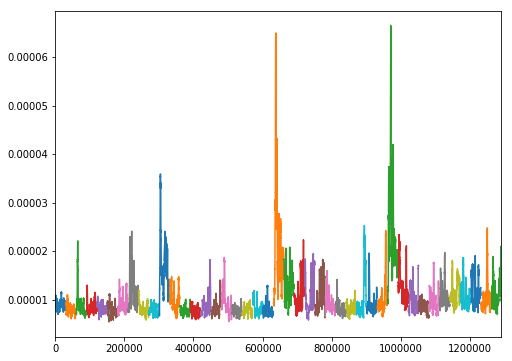

In [82]:
for n in df['block_number'].unique():
    df.loc[df['block_number']==n, 'P4'].rolling(fs*3).std().plot()

In [6]:
data_dirty.load_data(mode="useful")

In [9]:
len(data_dirty.data_list)

4

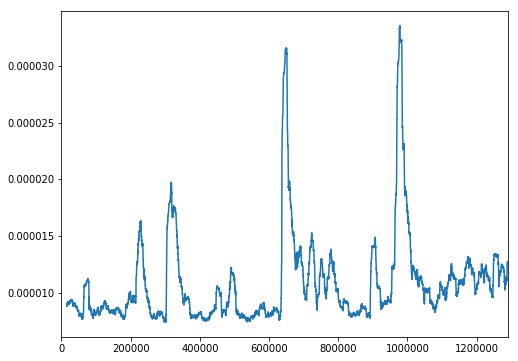

In [78]:
df['P4'].rolling(fs*30).std().plot()

In [83]:
srate = 500
order = 400
band = np.array([7, 14])
b = firwin(order, band*2/srate, width=None, window='hamming', pass_zero=False)
a = 1

df['P4_filtered'] = filtfilt(b, a, df['P4'])

In [86]:
df['P4_filtered_hilbert'] = hilbert(df['P4_filtered'])

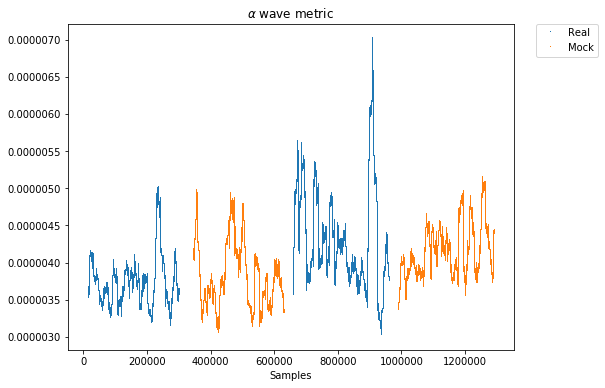

In [124]:
for name in ['Real', 'Mock']:
    plt.plot( 
        df.loc[df['block_name']==name, 'P4_filtered_hilbert'].abs().rolling(fs*30).mean(),
        ',',
        label = name
    )
plt.title(r'$\alpha$ wave metric')
plt.xlabel('Samples')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [109]:
srate = 500
order = 400
band = np.array([100, 104])
b = firwin(order, band*2/srate, width=None, window='hamming', pass_zero=False)
a = 1

df['P4_some_mio'] = abs(hilbert(filtfilt(b, a, df['P4'])))

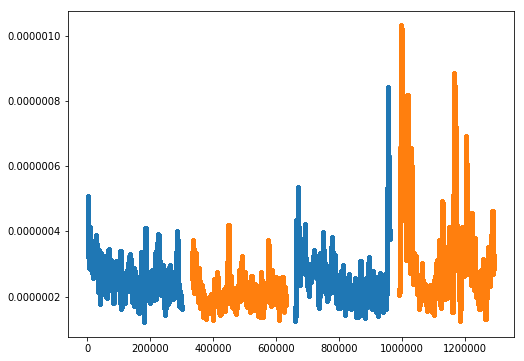

In [111]:
for name in ['Real', 'Mock']:
    plt.plot(df.loc[df['block_name']==name, 'P4_some_mio'].rolling(fs*5).mean(), '.')

In [125]:
df

,Fp1,Fp2,F7,F3,Fz,F4,F8,Ft9,Fc5,Fc1,...,P4,P8,O1,Oz,O2,block_name,block_number,P4_filtered,P4_filtered_hilbert,P4_some_mio
0,2.485351e-05,2.377930e-05,1.103516e-05,3.041992e-05,3.276367e-05,2.329102e-05,-9.765624e-07,4.541016e-06,1.108398e-05,2.836914e-05,...,-2.392578e-06,1.040039e-05,1.186523e-05,9.863281e-06,3.808594e-06,Real,1,-7.853225e-12,(-7.85322497833e-12-7.0780105107e-06j),2.647314e-09
1,2.382812e-05,2.148437e-05,1.147461e-05,2.724609e-05,2.919922e-05,2.167969e-05,0.000000e+00,5.615234e-06,1.147461e-05,2.597656e-05,...,-2.246094e-06,-1.806641e-06,1.020508e-05,7.714843e-06,-1.074219e-06,Real,1,1.421646e-06,(1.4216458396e-06-8.14047652242e-06j),2.307013e-08
2,2.011719e-05,2.333984e-05,1.123047e-05,2.373047e-05,2.768555e-05,2.470703e-05,6.396484e-06,4.882812e-06,1.411133e-05,2.333984e-05,...,2.343750e-06,-1.367187e-05,2.636719e-06,3.710937e-06,-4.492188e-06,Real,1,2.819377e-06,(2.81937665832e-06-8.17512969285e-06j),2.555243e-08
3,1.538086e-05,2.768555e-05,8.935546e-06,2.006836e-05,2.724609e-05,2.832031e-05,1.279297e-05,1.367187e-06,1.264648e-05,1.938476e-05,...,5.517578e-06,-5.615234e-06,-6.201172e-06,2.929687e-07,-1.660156e-06,Real,1,4.169689e-06,(4.16968872841e-06-8.15785723971e-06j),3.477638e-08
4,1.381836e-05,2.866211e-05,5.273437e-06,1.826172e-05,2.651367e-05,2.773438e-05,1.274414e-05,-1.269531e-06,6.933594e-06,1.704101e-05,...,3.808594e-06,5.322266e-06,-6.640625e-06,-3.417969e-07,9.765625e-08,Real,1,5.449932e-06,(5.44993228491e-06-7.71442395158e-06j),2.483344e-08
5,1.591797e-05,2.578125e-05,2.539063e-06,1.992187e-05,2.651367e-05,2.656250e-05,9.570313e-06,-2.343750e-06,3.759766e-06,1.860352e-05,...,6.494141e-06,-6.738281e-06,6.835937e-07,7.324219e-07,-4.589844e-06,Real,1,6.638707e-06,(6.63870705863e-06-7.19708116071e-06j),1.901953e-08
6,1.831055e-05,2.348633e-05,1.904297e-06,2.304687e-05,2.773438e-05,2.812500e-05,9.082031e-06,-3.027344e-06,5.810547e-06,2.182617e-05,...,1.503906e-05,-2.719727e-05,7.031250e-06,2.294922e-06,-9.277343e-06,Real,1,7.716242e-06,(7.71624238671e-06-6.39004584632e-06j),2.545164e-08
7,1.826172e-05,2.329102e-05,1.904297e-06,2.319336e-05,2.753906e-05,2.827148e-05,8.935546e-06,-2.685547e-06,8.251953e-06,2.187500e-05,...,1.669922e-05,-2.500000e-05,8.691406e-06,4.199218e-06,-6.298828e-06,Real,1,8.664747e-06,(8.66474708323e-06-5.51893199992e-06j),3.227263e-08
8,1.479492e-05,2.441406e-05,1.025391e-06,1.894531e-05,2.431640e-05,2.495117e-05,7.324219e-06,-1.269531e-06,6.738281e-06,1.713867e-05,...,1.030273e-05,2.441406e-07,7.275391e-06,6.835937e-06,4.248047e-06,Real,1,9.468723e-06,(9.46872264766e-06-4.43824274179e-06j),3.497325e-08
9,9.814453e-06,2.573242e-05,4.882812e-08,1.352539e-05,2.016602e-05,2.143555e-05,6.347656e-06,0.000000e+00,2.832031e-06,1.123047e-05,...,5.761719e-06,2.373047e-05,4.492188e-06,8.642578e-06,1.430664e-05,Real,1,1.011523e-05,(1.01152339405e-05-3.3197312086e-06j),3.826963e-08


In [ ]:
# settings
min_frequency = 1
max_frequency = 30
band = 2
srate = 500
order = 400
steps = 300 # number of permutations

for frequency in np.arange(min_frequency,frequencies):
    
    # filter dataset in particular band
    band = np.array([frequency, frequency+band])
    b = firwin(order, band*2/srate, width=None, window='hamming', pass_zero=False)
    a = 1
    df_filteed = filtfilt(b, a, df[channels])
    
    for step in np.arange(steps):
        pass
        


In [126]:
channels

['Fp1',
 'Fp2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'Ft9',
 'Fc5',
 'Fc1',
 'Fc2',
 'Fc6',
 'Ft10',
 'T3',
 'C3',
 'Cz',
 'C4',
 'T4',
 'Tp9',
 'Cp5',
 'Cp1',
 'Cp2',
 'Cp6',
 'Tp10',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'O1',
 'Oz',
 'O2']